# Heading

In [263]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

In [315]:
with open('house_prices_2018.csv', 'r') as csv:
    df = pd.read_csv(csv, header=None, usecols=[1,3], names=['house_price', 'postcode'])

df.head()

house_price  postcode
0       177000   LE4 6EE
1        90000  LE18 2AE
2       375000  LE11 3HG
3       142500   LE3 6UY
4       157500  LE13 0JH

In [301]:
df['postcode'] = df['postcode'].apply(lambda x: str(x)[:2]).str.replace('\d+', '')
df = df[df.postcode != 'na']
df.head()

house_price postcode
0       177000       LE
1        90000       LE
2       375000       LE
3       142500       LE
4       157500       LE

In [307]:
df_grouped = df.groupby('postcode').median().sort_values(by=['house_price'], ascending=True)
print(df_grouped.shape)
df_grouped.head()

(107, 1)


house_price
postcode             
DG            15000.0
SR           102000.0
DU           110995.0
BB           112500.0
OL           122750.0

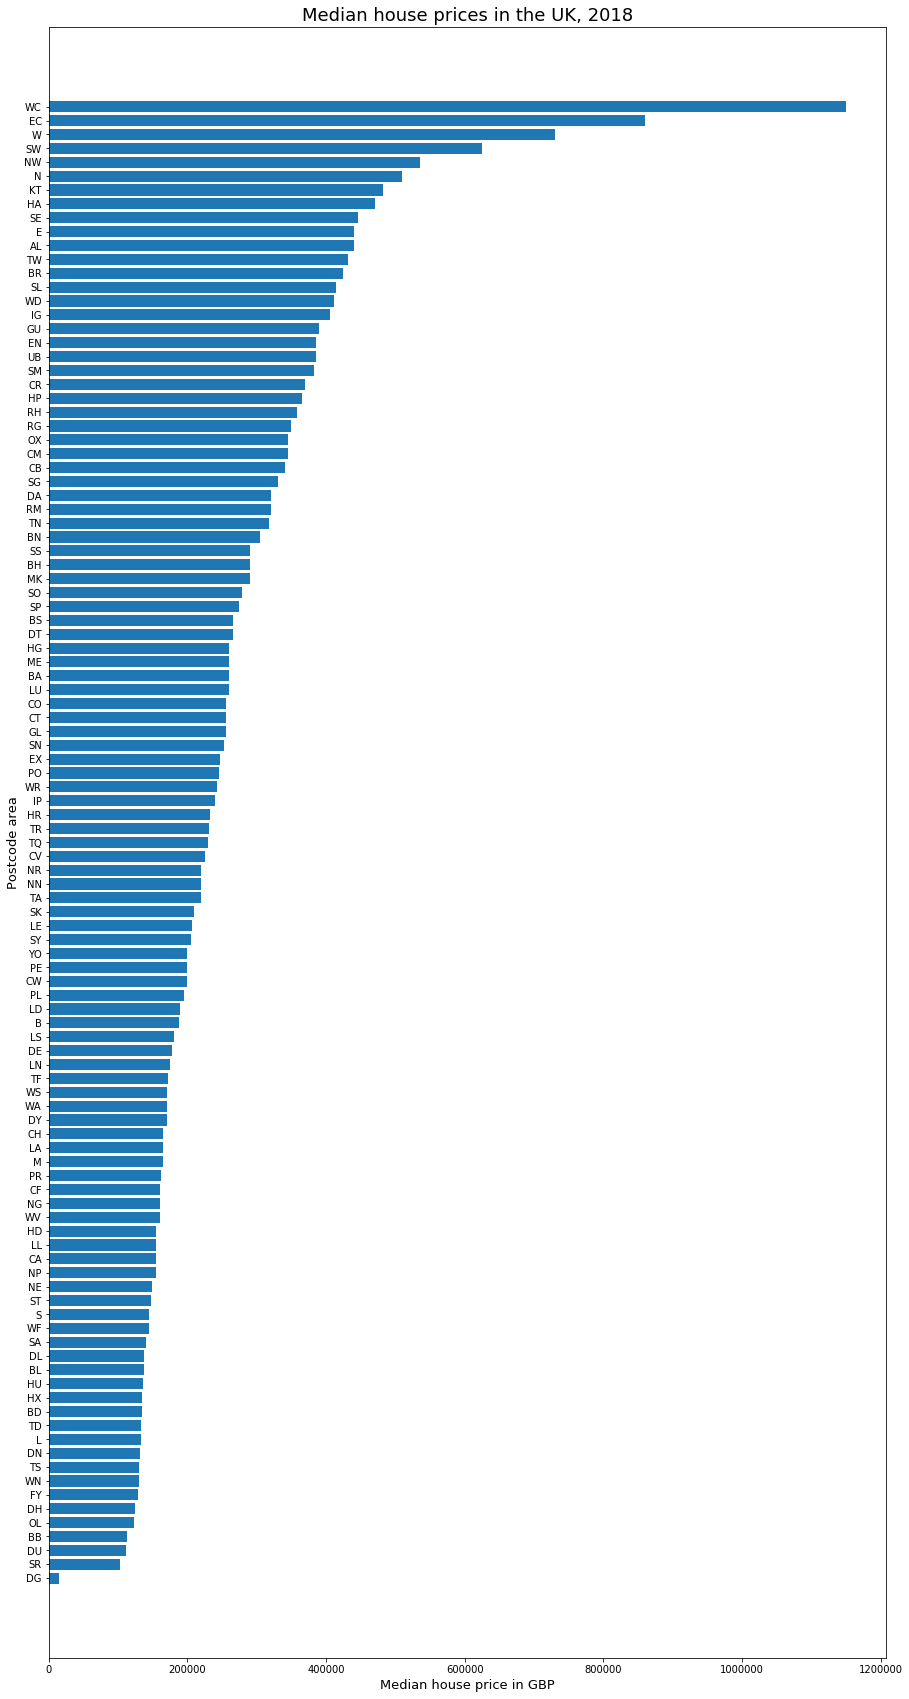

In [317]:
plt.figure(figsize=(15,30))
plt.barh(y=list(df_grouped.index), width=df_grouped['house_price'])
plt.xlabel('Median house price in GBP', fontsize=13)
plt.ylabel('Postcode area', fontsize=13)
plt.title('Median house prices in the UK, 2018', fontsize=18)
plt.show()

In [860]:
# download UK postcodes
#!wget -O postcodes.csv https://www.doogal.co.uk/files/postcodes.zip

# download UK crime data from 2018
#!wget -O crime_2018.csv https://www.ons.gov.uk/file?uri=/peoplepopulationandcommunity/crimeandjustice/datasets/policeforceareadatatables/yearendingdecember2018/policeforceareatablesyearendingdecember2018.xlsx

with open('postcodes.csv', 'r') as postcodes:
    soup = BeautifulSoup(postcodes)

print("Soup is ready!")

Soup is ready!


In [ ]:
postcodes = []
for area in soup.find_all('placemark'):
    if area.styleurl.string == '#active':
        postcode = area.find_all('name')[0].string[:-2] # we ignore the two last letters
        lng, lat = map(float, area.coordinates.string[:-2].split(','))
        postcodes.append([postcode, lat, lng])

postcodes_df = pd.DataFrame(postcodes)
postcodes_df.columns = ['Postcode', 'Latitude', 'Longitude']
postcodes_df = postcodes_df.groupby(['Postcode'], as_index=False).mean()

print(postcodes_df.shape)
postcodes_df.head()

In [1046]:
import opencage.geocoder

# set up geocoder
geocoder = opencage.geocoder.OpenCageGeocode('3021fe0dd4174d68bdcb156dbe1974e4')

def get_coords(query):
    return list(geocoder.geocode(query)[0]['geometry'].values())

bristol_coords = get_coords('Bristol, United Kingdom')
bristol_coords

[51.4538022, -2.5972985]

In [1047]:
import folium

bristol_map = folium.Map(location=bristol_coords, zoom_start=10)

for postcode, lat, lng in zip(postcodes_df['Postcode'], postcodes_df['Latitude'], postcodes_df['Longitude']):
    label = folium.Popup(str(postcode), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(bristol_map)

bristol_map

In [3]:
CLIENT_ID = '1CNA4A03C1G0DWB3U1MQLXRIX2L4HNONAH3JPPIPE3DW4I12' # Foursquare ID
CLIENT_SECRET = '5WQAJ1DW11TJ3O4HBCTSD1OPSXZSFU331BJ1EQ4F2HRQVN5P' # Foursquare Secret
VERSION = '20190428' # Foursquare API version

In [1]:
import requests

def get_url(lat, lng, rad=250, lim=100):
    return f"https://api.foursquare.com/v2/venues/explore?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}&ll={lat},{lng}&radius={rad}&limit={lim}"

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
           
        # create the API request URL
        url = get_url(lat=lat, lng=lng, rad=radius)
        
        try:
            # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except:
            continue
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postcode', 
                  'Postcode Latitude', 
                  'Postcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
bristol_venues = getNearbyVenues(names=postcodes_df['Postcode'],
                                 latitudes=postcodes_df['Latitude'],
                                 longitudes=postcodes_df['Longitude'],
                                 radius=250
                                )

# find number of unique categories
unique_cats = len(bristol_venues['Venue Category'].unique())

print(f"Found {bristol_venues.shape[0]} venues in Bristol spread among {unique_cats} unique categories. Here are a few of them:")
bristol_venues.head()

In [59]:
##### GET ALL FOURSQUARE CATEGORIES AND ELMO THEM

data = requests.get(f"https://api.foursquare.com/v2/venues/categories?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}").json()

categories = []
for x in data['response']['categories']:
    for y in x['categories']:
        categories.append(y['name'])
        
import tensorflow_hub as hub
import tensorflow as tf

# load the ELMo model
elmo_model = hub.Module("elmo", trainable=True)

embeddings = elmo_model(categories, signature="default", as_dict=True)["elmo"]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    elmo_values = sess.run(tf.reduce_mean(embeddings, 1))

elmo_df = pd.DataFrame(elmo_values)
elmo_df.index = categories

elmo_df.head()

W0503 12:41:40.218851  6668 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14
W0503 12:41:40.850426  6668 deprecation.py:323] From C:\Users\dn16382\AppData\Local\Programs\Python\Python37\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


0         1         2         3         4         5     \
Amphitheater   0.052971  0.076954  0.044281 -0.053049 -0.086353  0.004304   
Aquarium       0.202251 -0.053663  0.024427 -0.045254 -0.040375  0.058293   
Arcade         0.060543 -0.107114 -0.033095  0.028059  0.028740  0.025674   
Art Gallery   -0.079084 -0.242339  0.130979 -0.070507  0.222880 -0.291507   
Bowling Alley  0.206753 -0.061389  0.115527  0.058342 -0.021047 -0.161615   

                   6         7         8         9     ...      1014  \
Amphitheater   0.087412  0.177765  0.140873 -0.119384  ... -0.045384   
Aquarium       0.154257 -0.014278  0.023980  0.003998  ... -0.062350   
Arcade         0.157208  0.000662  0.146449 -0.270366  ...  0.082981   
Art Gallery    0.169687  0.284650 -0.120696  0.214101  ... -0.052833   
Bowling Alley -0.173363  0.003879 -0.001749  0.140480  ...  0.133437   

                   1015      1016      1017      1018      1019      1020  \
Amphitheater   0.068559  0.193767  0.038369  0.209967 -0.008164  0.115696   
Aquarium       0.037801  0.155037  0.096233  0.272292  0.111783 -0.033113   
Arcade         0.050621  0.160020 -0.076498  0.136790 -0.027340 -0.068318   
Art Gallery    0.062904 -0.081200  0.036670  0.289002 -0.058095  0.031156   
Bowling Alley  0.078221 -0.038693 -0.152419  0.194346  0.080593 -0.122651   

                   1021      1022      1023  
Amphitheater   0.164649  0.010889  0.018793  
Aquarium       0.198688  0.018255  0.052368  
Arcade         0.069327 -0.062674 -0.062816  
Art Gallery    0.260905  0.060784 -0.026933  
Bowling Alley  0.087201  0.056943  0.102686  

[5 rows x 1024 columns]

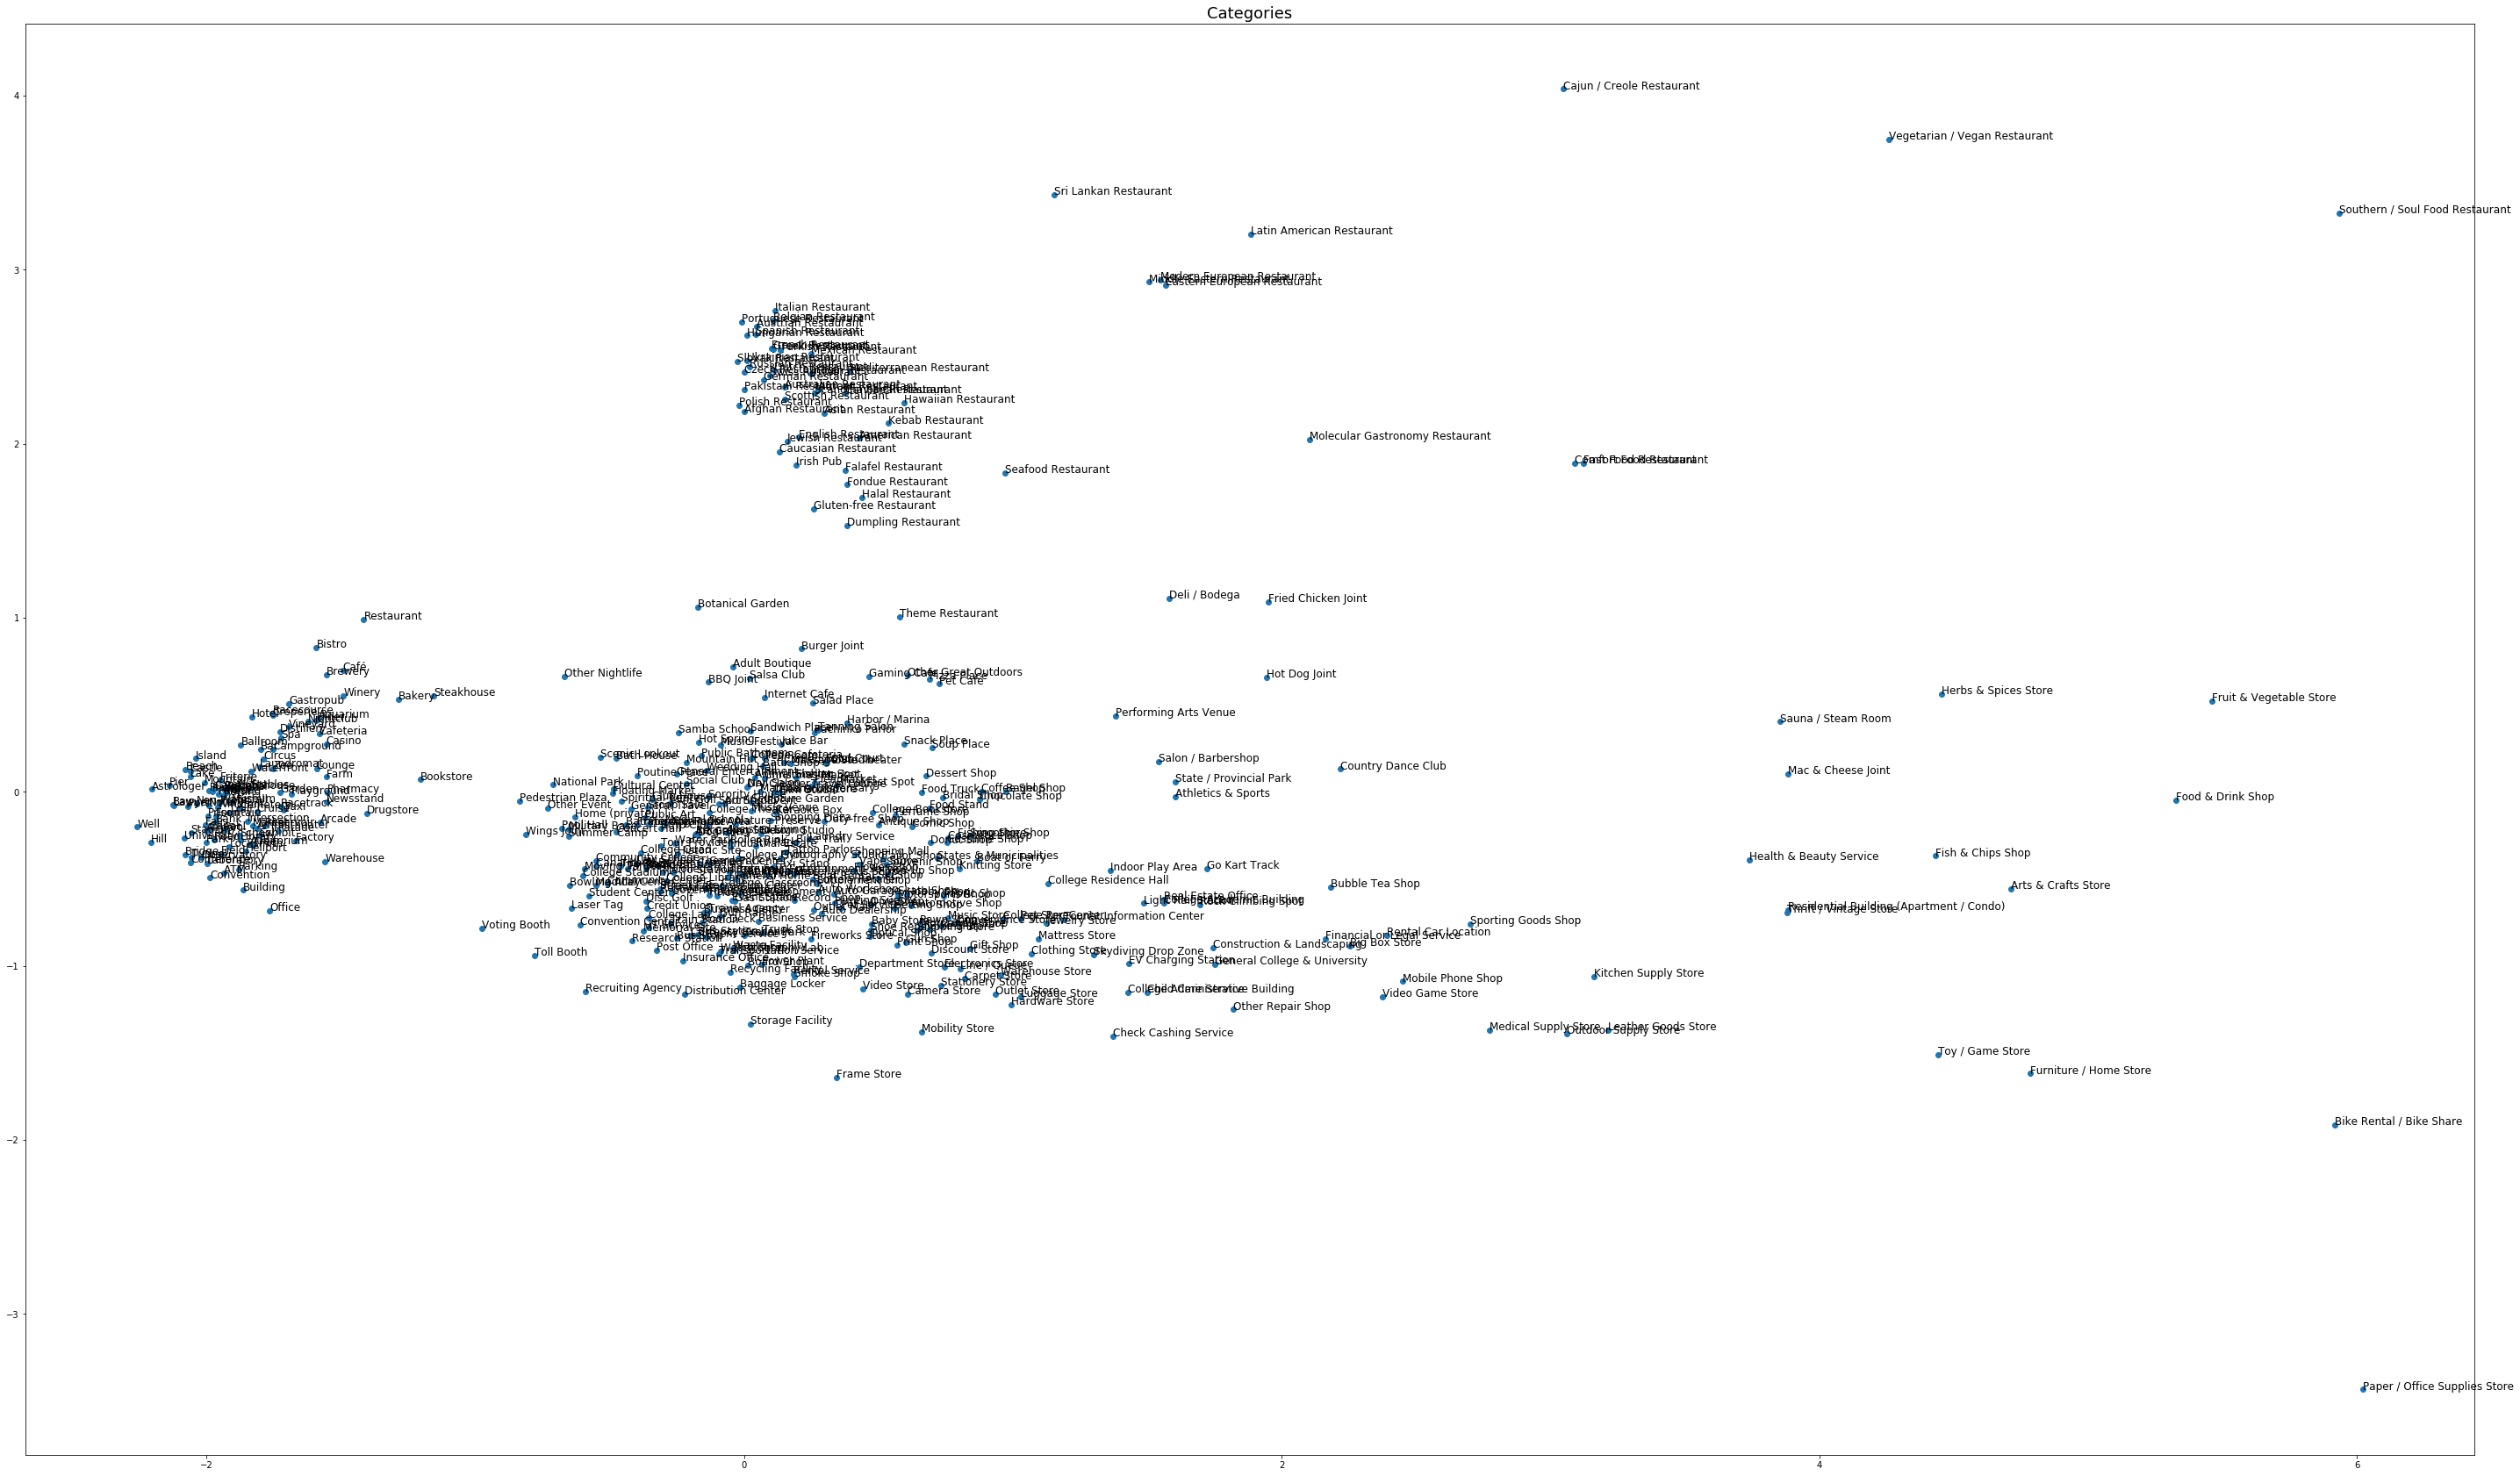

In [61]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
elmo_2d = pca.fit_transform(elmo_values)
elmo_2d_df = pd.DataFrame(elmo_2d)

# plot the ELMo'd categories
plt.figure(figsize=(50,30))

x = np.dot(elmo_2d, [1,0])
y = np.dot(elmo_2d, [0,1])

plt.scatter(x, y)
plt.title('Categories', fontsize=18)

for i, cat in enumerate(categories):
    plt.text(x[i], y[i], cat, fontsize=12)

plt.show()

In [199]:
# DBSCAN clustering of categories

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=3.5, min_samples=2).fit(elmo_df)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

cat_series = elmo_df.copy()

# add clustering labels
cat_series.insert(0, 'Category', labels)
cat_series = cat_series['Category']

print(f"We aggregated {len(categories)} categories into {len(set(labels))-1+cat_series.value_counts()[-1]}.")

We aggregated 456 categories into 213.


In [200]:
cat_series.value_counts()

-1     191
 0     154
 9      52
 4      10
 1       7
 14      6
 2       3
 13      3
 20      2
 8       2
 3       2
 5       2
 6       2
 7       2
 10      2
 19      2
 21      2
 12      2
 15      2
 16      2
 17      2
 18      2
 11      2
Name: Category, dtype: int64

In [201]:
df = pd.DataFrame([list(cat_series.index), list(cat_series.values)]).T
df.columns = ['Category', 'Cluster']

pd.set_option('display.max_colwidth', 300)
df.groupby('Cluster').agg(lambda x: ','.join(x))

Category
Cluster                                                                                                                                                                                                                                                                                                             
-1       Bowling Alley,Comedy Club,Concert Hall,Country Dance Club,Disc Golf,General Entertainment,Go Kart Track,Historic Site,Karaoke Box,Laser Tag,Memorial Site,Mini Golf,Movie Theater,Pachinko Parlor,Performing Arts Venue,Public Art,Roller Rink,Salsa Club,Tour Provider,Water Park,College Academic Buil...
 0       Amphitheater,Aquarium,Arcade,Casino,Circus,Exhibit,Museum,Pool Hall,Racecourse,Racetrack,Samba School,Stadium,Zoo,University,Conference,Convention,Festival,Parade,Afghan Restaurant,African Restaurant,American Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,Bakery,Belgian Re...
 1                                                                                                                                                                                                                Art Gallery,Art Studio,Design Studio,Film Studio,Massage Studio,Photography Lab,Photography Studio
 2                                                                                                                                                                                                                                                                            Music Venue,Music Festival,Music Store
 3                                                                                                                                                                                                                                                                                       Theme Park,Theme Restaurant
 4                                                                                                                                                     College Auditorium,College Bookstore,College Cafeteria,College Classroom,College Gym,College Lab,College Library,College Quad,College Stadium,College Theater
 5                                                                                                                                                                                                                                                                                Community College,Community Center
 6                                                                                                                                                                                                                                                                                   Fraternity House,Sorority House
 7                                                                                                                                                                                                                                                                                     Medical School,Medical Center
 8                                                                                                                                                                                                                                                                                       Other Event,Other Nightlife
 9       Bagel Shop,Coffee Shop,Dessert Shop,Donut Shop,Bike Trail,Dive Spot,Fishing Spot,Antique Shop,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,Batik Shop,Bike Shop,Bridal Shop,Candy Store,Carpet Store,Chocolate Shop,Clothing Store,Convenience Store,Cosmetics Shop,Discount Store,Dive Sho...
 10                                                                                                                                                                                                                                                                                        

## Reducing the amount of categories

In [867]:
import tensorflow_hub as hub
import tensorflow as tf

categories = np.asarray(bristol_venues['Venue Category'].unique())

# load the ELMo model
elmo_model = hub.Module("elmo", trainable=True)

embeddings = elmo_model(categories, signature="default", as_dict=True)["elmo"]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    elmo_values = sess.run(tf.reduce_mean(embeddings, 1))

elmo_df = pd.DataFrame(elmo_values)
elmo_df.index = categories

elmo_df.head()

0         1         2         3         4     \
Coffee Shop         -0.095961 -0.250358  0.175229  0.023804  0.047250   
Beer Bar             0.054975 -0.175929  0.202982  0.011062  0.020331   
Market               0.032854 -0.162732 -0.135469  0.017576  0.004281   
Lounge              -0.028766 -0.179883  0.053728  0.021002 -0.087067   
Japanese Restaurant  0.146972 -0.224561  0.143659 -0.070366  0.222073   

                         5         6         7         8         9     ...  \
Coffee Shop         -0.081503 -0.005880 -0.018814 -0.111119 -0.026370  ...   
Beer Bar            -0.025837 -0.067953  0.184497 -0.054263  0.048842  ...   
Market              -0.138709  0.019799  0.049910 -0.184751 -0.036926  ...   
Lounge               0.006248  0.059978  0.063289  0.073869 -0.114890  ...   
Japanese Restaurant -0.056010  0.147965 -0.185041 -0.114336 -0.254158  ...   

                         1014      1015      1016      1017      1018  \
Coffee Shop         -0.067655 -0.032707 -0.060837  0.141322  0.168532   
Beer Bar            -0.007018  0.137447 -0.034237 -0.011601  0.159704   
Market              -0.012916 -0.069320  0.126890  0.074640  0.158289   
Lounge               0.140220  0.115738  0.027025  0.042133  0.286032   
Japanese Restaurant -0.106775  0.046899 -0.011663  0.038437  0.331340   

                         1019      1020      1021      1022      1023  
Coffee Shop         -0.083866  0.019239  0.247801 -0.090725 -0.023675  
Beer Bar             0.044829  0.051540  0.130122 -0.035663 -0.212370  
Market               0.106466  0.103340  0.089366 -0.015475 -0.018664  
Lounge               0.077852  0.038122  0.149637 -0.117770 -0.020474  
Japanese Restaurant -0.080974 -0.033975  0.118037  0.021531 -0.067160  

[5 rows x 1024 columns]

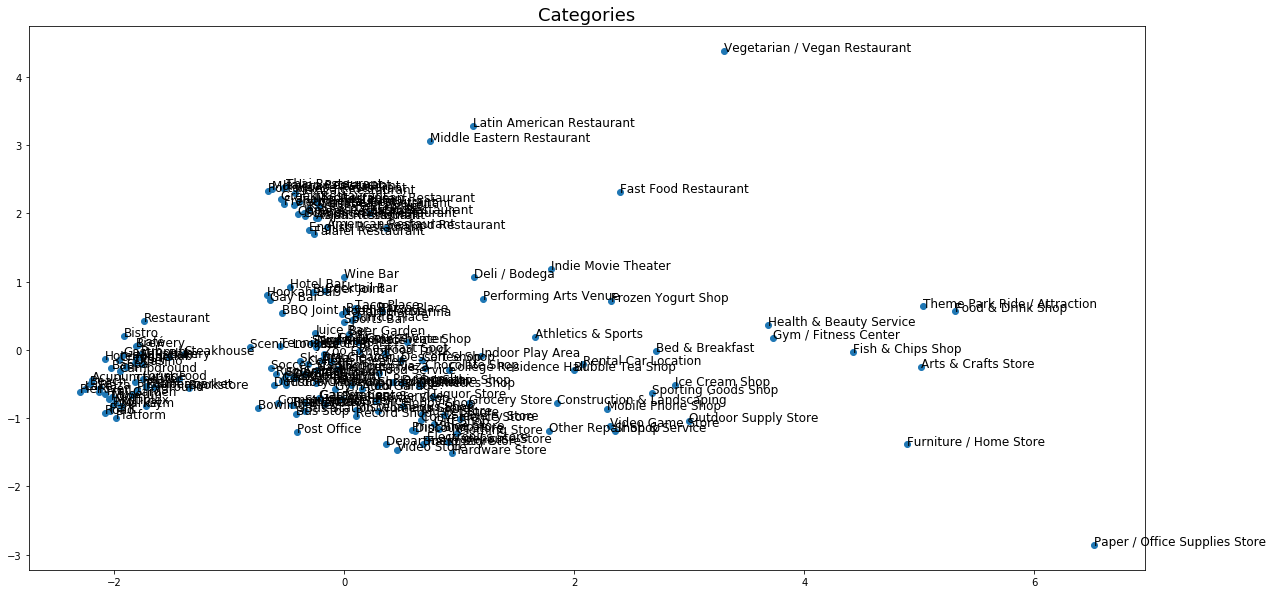

In [868]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
elmo_2d = pca.fit_transform(elmo_values)
elmo_2d_df = pd.DataFrame(elmo_2d)

# plot the ELMo'd categories
plt.figure(figsize=(30,20))

x = np.dot(elmo_2d, [1,0])
y = np.dot(elmo_2d, [0,1])

plt.scatter(x, y)
plt.title('Categories', fontsize=18)

for i, cat in enumerate(categories):
    plt.text(x[i], y[i], cat, fontsize=12)

plt.show()

In [109]:
# DBSCAN clustering of categories

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=2, min_samples=1).fit(elmo_df)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

cat_series = elmo_df.copy()

# add clustering labels
cat_series.insert(0, 'Category', labels)
cat_series = cat_series['Category']

print(f"We aggregated {unique_cats} categories into {len(set(labels))-1+cat_series.value_counts()[-1]}.")

NameError: name 'unique_cats' is not defined

In [108]:
cat_series.value_counts()[:10]

391

In [972]:
new_cats = bristol_venues.copy()['Venue Category']
new_cats = new_cats.apply(lambda x: cat_series[x])
new_cats = new_cats.values

new_cats

array([0, 0, 1, ..., 1, 1, 1], dtype=int64)

## Clustering neighbourhoods

In [973]:
# one hot encoding
bristol_onehot = pd.get_dummies(new_cats, prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
bristol_onehot['Postcode'] = bristol_venues['Postcode'] 

# move neighbourhood column to the first column
fixed_columns = [bristol_onehot.columns[-1]] + list(bristol_onehot.columns[:-1])
bristol_onehot = bristol_onehot[fixed_columns]

bristol_onehot.head(3)

Postcode  0  1  2  3  4  5  6  7  8  ...  78  79  80  81  82  83  84  85  \
0    BS1 1  1  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
1    BS1 1  1  0  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   
2    BS1 1  0  1  0  0  0  0  0  0  0  ...   0   0   0   0   0   0   0   0   

   86  87  
0   0   0  
1   0   0  
2   0   0  

[3 rows x 89 columns]

In [974]:
bristol_grouped = bristol_onehot.groupby('Postcode').mean().reset_index()
bristol_grouped.head(3)

Postcode         0         1         2     3         4       5         6  \
0    BS1 1  0.130000  0.440000  0.200000  0.01  0.020000  0.0100  0.010000   
1    BS1 2  0.137500  0.425000  0.237500  0.00  0.037500  0.0125  0.012500   
2    BS1 3  0.090909  0.340909  0.227273  0.00  0.045455  0.0000  0.022727   

          7       8  ...   78   79   80   81   82   83   84   85   86   87  
0  0.010000  0.0100  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1  0.012500  0.0125  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
2  0.022727  0.0000  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[3 rows x 89 columns]

In [1039]:
# DBSCAN clustering of neighbourhoods

from sklearn.cluster import DBSCAN

db = DBSCAN(eps=.1, min_samples=3).fit(bristol_grouped.drop('Postcode', 1))
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# create copy of nbhds_venues_sorted
nbhd_clusters = bristol_grouped.copy()[['Postcode']]

# add clustering labels
nbhd_clusters.insert(0, 'Cluster Labels', labels)

# merge bristol_grouped with bristol data to add latitude/longitude for each neighborhood
bristol_merged = postcodes_df.join(nbhd_clusters.set_index('Postcode'), on='Postcode')

# drop neighbourhoods with no venues
bristol_merged.dropna(subset=['Cluster Labels'], inplace=True)

# convert cluster labels to integers
bristol_merged['Cluster Labels'] = bristol_merged['Cluster Labels'].astype('int32')

bristol_merged.head()

Postcode   Latitude  Longitude  Cluster Labels
0    BS1 1  51.454110  -2.593955               0
1    BS1 2  51.456632  -2.593386               0
2    BS1 3  51.458907  -2.589088              -1
3    BS1 4  51.451699  -2.595637               0
4    BS1 5  51.452887  -2.601904               0

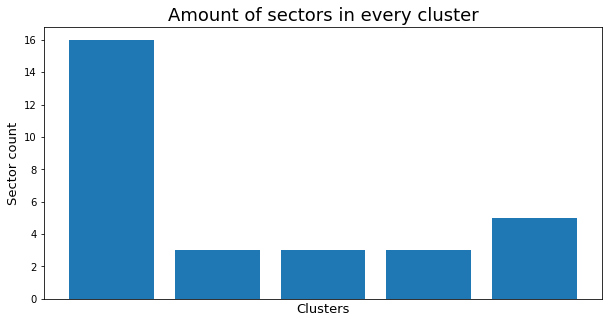

In [1040]:
# find total amount of clusters
total_clusters = len(bristol_merged['Cluster Labels'].unique())

# count how many sectors are in each cluster
cluster_count = bristol_merged.groupby(['Cluster Labels']).count()['Postcode'][2:]

# plot distribution of clusters
plt.figure(figsize=(10,5))
plt.bar(x=cluster_count.index, height=cluster_count.values)
plt.xlabel('Clusters', fontsize=13)
plt.ylabel('Sector count', fontsize=13)
plt.title('Amount of sectors in every cluster', fontsize=18)
plt.xticks([])
plt.show()

In [1041]:
# install if needed
#!pip install folium

import folium # displays maps
import matplotlib.cm as cm
import matplotlib.colors as colors
from random import shuffle

# create map
map_clusters = folium.Map(location=bristol_coords, zoom_start=10)

# set color scheme for the clusters
x = np.arange(total_clusters)
ys = [i + x + (i*x)**2 for i in range(total_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))

rainbow = [colors.rgb2hex(i) for i in colors_array]
shuffle(rainbow)

# add markers to the map
markers_colors = []
for lat, lng, postcode, cluster in zip(bristol_merged['Latitude'], bristol_merged['Longitude'], bristol_merged['Postcode'], bristol_merged['Cluster Labels']):
    if cluster != -1:
        label = folium.Popup(str(postcode) + f'\nCluster {cluster}', parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=rainbow[cluster],
            fill=True,
            fill_color=rainbow[cluster],
            fill_opacity=1).add_to(map_clusters)

map_clusters

Do another DSCAN by geographical coordinates to find 'bubbles'